In [148]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from skimage import data, color, graph, filters
from skimage.util import img_as_float32
from skimage.segmentation import quickshift, mark_boundaries, expand_labels

from sklearn.utils import shuffle
from sklearn.cluster import MeanShift, KMeans, estimate_bandwidth

In [2]:
def extract_feat(image: np.ndarray) -> pd.DataFrame:
    image_data = np.ndarray((image.shape[0] * image.shape[1], 5))
    for i, row in enumerate(image):
        for j, value in enumerate(row):
            image_data[i * image.shape[1] + j] = [*value, i, j]
    return pd.DataFrame(image_data, columns=['R', 'G', 'B', 'x', 'y']).\
           astype({'x': 'int64', 'y': 'int64'})
def label_image(flattened_image: pd.DataFrame, labels: np.ndarray) -> np.ndarray:
    max_x = int(flattened_image.max()['x'])
    max_y = int(flattened_image.max()['y'])
    image_labels = np.ndarray((max_x + 1, max_y + 1), dtype=np.int64)
    for i, row in flattened_image.iterrows():
        image_labels[int(row['x']), int(row['y'])] = labels[i]
    return image_labels

In [63]:
# image is stored as arrays of pixels, pixel might be represented in
# different variety of colourspace. data.camera() for example is 
# gray-scale, hence each pixel is a value of lightness.
# data.astronaut() is colored, each pixel is instead a vector in RGB space 
image = img_as_float32(data.astronaut())

In [69]:
image_df = extract_feat(image)
# shuffled_sample = shuffle(image_df, random_state=0)
train = image_df[['R', 'G', 'B']]

In [189]:
bandwidth = estimate_bandwidth(train, n_samples=1000, quantile=.6, random_state=0)
bandwidth

np.float64(0.7217373504825837)

In [205]:
mean_shift = MeanShift(bandwidth=0.2, bin_seeding=True, max_iter=500, cluster_all=False)
ms_label = mean_shift.fit_predict(train)
labels = label_image(image_df, ms_label)
labels

array([[-1, -1, -1, ..., -1, -1, -1],
       [ 0, -1, -1, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       ...,
       [ 0,  0,  0, ...,  1,  1,  1],
       [ 0,  0,  0, ...,  1,  1,  1],
       [ 0,  0,  0, ...,  1,  1,  1]])

In [117]:
kmean = KMeans(n_clusters=8, random_state=0)
km_label = kmean.fit_predict(train)
labels = label_image(image_df, km_label)
labels

array([[7, 7, 7, ..., 4, 4, 4],
       [7, 7, 7, ..., 4, 4, 4],
       [7, 7, 7, ..., 4, 4, 4],
       ...,
       [3, 3, 3, ..., 5, 5, 5],
       [3, 3, 3, ..., 5, 5, 5],
       [3, 3, 3, ..., 5, 5, 5]])

In [207]:
labels = quickshift(image, kernel_size=3, max_dist=6, ratio=0.5, convert2lab=False)
labels

array([[  0,   0,   0, ...,   3,   3,   3],
       [  0,   0,   0, ...,   3,   3,   3],
       [  0,   0,   0, ...,   3,   3,   3],
       ...,
       [799, 799, 799, ..., 808, 808, 808],
       [799, 799, 799, ..., 808, 808, 808],
       [799, 799, 799, ..., 808, 808, 808]])

In [226]:
rag = graph.rag_mean_color(image, labels, mode='similarity', sigma=100)
# edges = filters.sobel(color.rgb2gray(image))
# rag = graph.rag_boundary(labels, edges)
labels2 = graph.cut_threshold(labels, rag, 0.99)
# labels2 = graph.cut_normalized(labels, rag, thresh=0.5)
# labels2 = graph.merge_hierarchical(labels, rag,
#                                    thresh=0.08, rag_copy=True,
#                                    in_place_merge=True,
#                                    merge_func=lambda x, y, z: None,
#                                    weight_func=weight_boundary)
# labels2 = expand_labels(labels, distance=0.005)
# labels2 = labels
np.unique(labels2)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

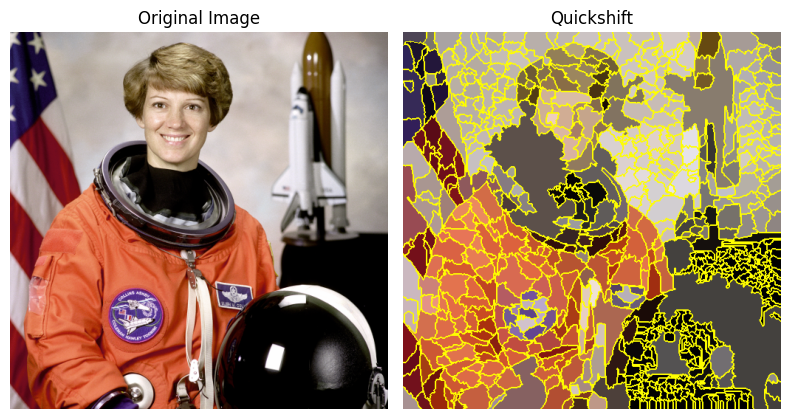

In [227]:
out = color.label2rgb(labels2, image, kind='avg', bg_label=-1, image_alpha=0, alpha=1)
out = mark_boundaries(out, labels2)

fig = plt.figure(figsize=(8, 8))

ax1 = fig.add_subplot(121)

ax2 = fig.add_subplot(122)

ax1.imshow(image)
ax1.set_axis_off()
ax1.set_title("Original Image", fontsize=12)

title = f'Quickshift'
ax2.imshow(out)
ax2.set_axis_off()
ax2.set_title(title, fontsize=12)

fig.tight_layout()
plt.show()